# Plot iterations as functions of M and rho

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from corrcalc import CorrelationCalculator
from pych import read_jacobi_iters

In [2]:
plt.style.use('./presentation.mplstyle')

In [3]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [4]:
def read_iters(n_range, n_apps, **kwargs):
    
    cc = CorrelationCalculator(n_range=n_range, n_applications=n_apps, **kw)
    iters = read_jacobi_iters(f"{cc.run_dir}/STDOUT.0000", which_jacobi="3D")
    
    sample_skip = np.arange(0, cc.n_samples*n_apps, n_apps)
    total = np.array([
        np.sum(iters[i:i+n_apps]) for i in sample_skip
    ])
    iter_per_m = np.array([
        np.mean(iters[i:i+n_apps]) for i in sample_skip
    ])
    
    xds = xr.Dataset()
    sample = np.arange(cc.n_samples)
    xds['sample'] = xr.DataArray(sample, coords={'sample': sample}, dims=('sample',))
    xds['total'] = xr.DataArray(total, coords=xds.sample.coords, dims=xds.sample.dims)
    xds['avg_per_m'] = xr.DataArray(iter_per_m, coords=xds.sample.coords, dims=xds.sample.dims)
    
    xds = cc.expand_dims(xds)
    return xds

In [5]:
kw = {'log10tol': -3,
      'n_samples': 1000,
      'persist': False,
      }

dslist1 = []
for n_range in [5, 10, 15, 20]:
    dslist2 = []
    for n_apps in [1, 2, 4, 8]:
        
        tmp = read_iters(n_range=n_range, n_apps=n_apps, **kw)
        
        dslist2.append(tmp)
    dslist1.append(xr.concat(dslist2, dim='n_applications'))
    
ds = xr.concat(dslist1, dim='n_range')
ds = ds.squeeze()

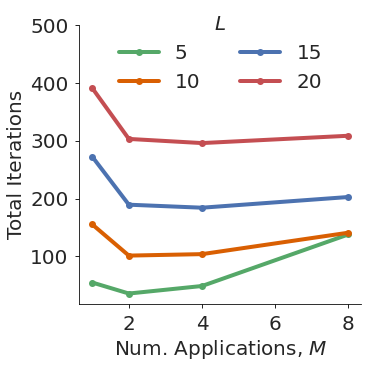

In [7]:
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

xlabel = 'Num. Applications, $M$'
pkw = {'x':'n_applications',
       'marker':'o',
       'add_legend': False}

plotme = ds.total.mean('sample')
plotme.plot.line(ax=ax,**pkw)
ax.set(title='',
       ylabel='Total Iterations',
       xlabel='Num. Applications, $M$',
       ylim=[None, 500],
      )

#leg = ax.get_legend()
ax.legend(labels=[int(rho) for rho in ds.n_range.values],
          title=r'$L$',
          ncol=2,
          loc='upper center',
          bbox_to_anchor=(0.5,1.1),
          )
fig.savefig(f'{fig_dir}/iterations_vs_applications_singlepanel.pdf', bbox_inches='tight')